# Week 7 Lab: Text Analytics

This week's assignment will focus on text analysis of BBC News articles.

## Our Dataset: 
**Dataset:** bbc.csv(Provided in folder assign_wk7)<br>
Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005. <br>
Class Labels: 5 (business, entertainment, politics, sport, tech)

## Text Analytics Lab

**Objective:** 
To demostrate all of the text analysis techniques covered int his week's lecture material. Your submission needs to include the following:
   - Preparation of the text data for analysis
       * Elimination of stopwords, punctuation, digits, lowercase
   - Identify the 10 most frequently used words in the text
       * How about the ten least frequently used words? 
       * How does lemmatization change the most/least frequent words?
           - Explain and demonstrate this topic
   - Generate a world cloud for the text
   - Demonstrate the generation of n-grams and part of speech tagging
   - Create a Topic model of the text
       * Find the optimal number of topics
       * test the accuracy of your model
       * Display your results 2 different ways.
           1) Print the topics and explain any insights at this point.
           2) Graph the topics and explain any insights at this point.



## I. Introduction

This weeks analysis is on at text dataset of news stories from the BBC. These BBC news articles are given with an index and a type. Our output for this weeks lab is the creation and display of the topics that we mine from the text of these BBC articles. The number and accuracy of the topics will be maximized with the best values used for final evaluation.

## II. Methods/Code, III. Results/Output, IV. Analysis of Results

### Setup
---

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
from nltk.tag import pos_tag

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

from wordcloud import WordCloud
import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/home/tosterberg/.local/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
!head assign_wk7/bbc.csv

id,news,type
0,"UK economy facing 'major risks'
 
 The UK manufacturing sector will continue to face ""serious challenges"" over the next two years, the British Chamber of Commerce (BCC) has said.
 
 The group's quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced ""major risks"" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.
 
 Manufacturers' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.
 
 ""Despite some positive news for the export sector, there are worrying signs for manufacturing,"" the BCC said. ""These results reinforce our concern ov

It looks like our article length is pretty long, so I am expecting a lot of stop words and other reporting filler that will need to be addressed to improve our topics at the end.

In [3]:
bbc_df = pd.read_csv('assign_wk7/bbc.csv', index_col='id')
bbc_df

,news,type
id,,
0,UK economy facing 'major risks'\n \n The UK ma...,business
1,Aids and climate top Davos agenda\n \n Climate...,business
2,Asian quake hits European shares\n \n Shares i...,business
3,India power shares jump on debut\n \n Shares i...,business
4,Lacroix label bought by US firm\n \n Luxury go...,business
...,...,...
2220,Warning over Windows Word files\n \n Writing a...,tech
2221,Fast lifts rise into record books\n \n Two hig...,tech
2222,Nintendo adds media playing to DS\n \n Nintend...,tech


In [4]:
print(bbc_df.news[0])

UK economy facing 'major risks'
 
 The UK manufacturing sector will continue to face "serious challenges" over the next two years, the British Chamber of Commerce (BCC) has said.
 
 The group's quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced "major risks" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.
 
 Manufacturers' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.
 
 "Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said. "These results reinforce our concern over the sector's persist

In [5]:
print(bbc_df.news[315])

UK bank seals South Korean deal
 
 UK-based bank Standard Chartered said it would spend $3.3bn (£1.8bn) to buy one of South Korea's main retail banks.
 
 Standard Chartered said acquiring Korea First Bank (KFB) fulfilled a strategic objective of building a bigger presence in Asia's third largest economy. Its shares fell nearly 3% in London as the bank raised funds for the deal by selling new stocks worth £1bn ($1.8bn), equal to 10% of its share capital. Standard Chartered expects about 16% of future group revenue to come from KFB.
 
 The South Korean bank will also make up 22% of the group's total assets. The move, a year after Citigroup beat Standard Chartered to buy Koram bank, would be the South Korean financial sector's biggest foreign takeover. This time around, Standard Chartered is thought to have beaten HSBC to the deal. KFB is South Korea's seventh largest bank, with 3 million retail customers, 6% of the country's banking market and an extensive branch network.
 
 The country'

- **Categorical vs numeric columns in your dataset**

In [6]:
bbc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 116.7+ KB


In [7]:
bbc_df.type.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: type, dtype: int64

It does not look like there is much to this dataset other than the five types that the articles in news are assigned to and an index.

- **Word count**

Starting our analysis we should get a feel for the size of the articles that we are performing our analysis on.

In [8]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

bbc_df['word_cnt'] = bbc_df.news.apply(lambda x: len(str(x).split(" ")))

In [9]:
bbc_df.head(5)

,news,type,word_cnt
id,,,
0,UK economy facing 'major risks'\n \n The UK ma...,business,329
1,Aids and climate top Davos agenda\n \n Climate...,business,454
2,Asian quake hits European shares\n \n Shares i...,business,553
3,India power shares jump on debut\n \n Shares i...,business,175
4,Lacroix label bought by US firm\n \n Luxury go...,business,152


In [10]:
bbc_df.word_cnt.describe()

count    2225.000000
mean      388.967640
std       241.594413
min        91.000000
25%       249.000000
50%       336.000000
75%       477.000000
max      4489.000000
Name: word_cnt, dtype: float64

<AxesSubplot:xlabel='word_cnt', ylabel='Count'>

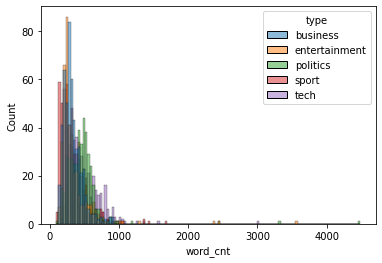

In [11]:
sns.histplot(data=bbc_df, x='word_cnt', hue='type')

- **Character count**

Here we will do the same context building that we did with word count with the number of characters.

In [12]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

bbc_df['char_cnt'] = bbc_df.news.str.len()

In [13]:
bbc_df.head(5)

,news,type,word_cnt,char_cnt
id,,,,
0,UK economy facing 'major risks'\n \n The UK ma...,business,329,1996
1,Aids and climate top Davos agenda\n \n Climate...,business,454,2727
2,Asian quake hits European shares\n \n Shares i...,business,553,3444
3,India power shares jump on debut\n \n Shares i...,business,175,1038
4,Lacroix label bought by US firm\n \n Luxury go...,business,152,894


In [14]:
bbc_df.char_cnt.describe()

count     2225.000000
mean      2274.733483
std       1370.571487
min        507.000000
25%       1454.000000
50%       1979.000000
75%       2815.000000
max      25597.000000
Name: char_cnt, dtype: float64

<AxesSubplot:xlabel='char_cnt', ylabel='Count'>

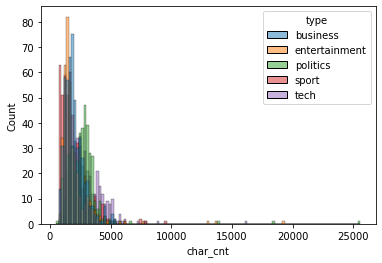

In [15]:
sns.histplot(data=bbc_df, x='char_cnt', hue='type')

- **Stopwords**

In [16]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View
stop = stopwords.words('english')

bbc_df['stopwords'] = bbc_df.news.apply(lambda x: len([x for x in x.split() if x in stop]))

In [17]:
bbc_df.head(5)

,news,type,word_cnt,char_cnt,stopwords
id,,,,,
0,UK economy facing 'major risks'\n \n The UK ma...,business,329,1996,112
1,Aids and climate top Davos agenda\n \n Climate...,business,454,2727,161
2,Asian quake hits European shares\n \n Shares i...,business,553,3444,171
3,India power shares jump on debut\n \n Shares i...,business,175,1038,55
4,Lacroix label bought by US firm\n \n Luxury go...,business,152,894,47


In [18]:
bbc_df.stopwords.describe()

count    2225.000000
mean      144.644045
std        99.353146
min        16.000000
25%        89.000000
50%       125.000000
75%       178.000000
max      1917.000000
Name: stopwords, dtype: float64

<AxesSubplot:xlabel='stopwords', ylabel='Count'>

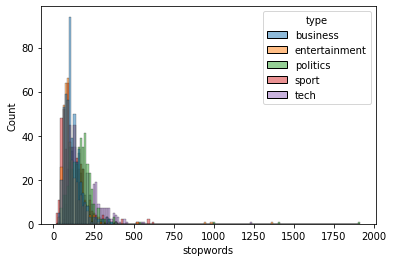

In [19]:
sns.histplot(data=bbc_df, x='stopwords', hue='type')

### Data Cleanup
***

Now that we have looked into the composition of the articles we will be doing our text analysis on we can see that we need to now create a cleaned version of the text for the next analysis. This will included removing of the stopwords that we counted, and getting the text into a regular format. In this case we will be doing this with lowercase, without numbers or punctuation.

#### Preparation of the text data for analysis
---

- **Covert Text to Lowercase**

In [20]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

bbc_df['clean_text'] = bbc_df.news.apply(lambda x: " ".join(x.lower() for x in x.split()))

In [21]:
bbc_df.clean_text[0]

'uk economy facing \'major risks\' the uk manufacturing sector will continue to face "serious challenges" over the next two years, the british chamber of commerce (bcc) has said. the group\'s quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. the rise came despite exchange rates being cited as a major concern. however, the bcc found the whole uk economy still faced "major risks" and warned that growth is set to slow. it recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006. manufacturers\' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. employment in manufacturing also fell and job expectations were at their lowest level for a year. "despite some positive news for the export sector, there are worrying signs for manufacturing," the bcc said. "these results reinforce our concern over the sector\'s persistent in

- **Removing Punctuation**

In [22]:
bbc_df['clean_text'] = bbc_df.clean_text.str.replace('[^\w\s]','')

In [23]:
bbc_df.clean_text[0]

'uk economy facing major risks the uk manufacturing sector will continue to face serious challenges over the next two years the british chamber of commerce bcc has said the groups quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years the rise came despite exchange rates being cited as a major concern however the bcc found the whole uk economy still faced major risks and warned that growth is set to slow it recently forecast economic growth will slow from more than 3 in 2004 to a little below 25 in both 2005 and 2006 manufacturers domestic sales growth fell back slightly in the quarter the survey of 5196 firms found employment in manufacturing also fell and job expectations were at their lowest level for a year despite some positive news for the export sector there are worrying signs for manufacturing the bcc said these results reinforce our concern over the sectors persistent inability to sustain recovery the outl

- **Removing Digits**

In [24]:
bbc_df['clean_text'] = bbc_df.clean_text.str.replace('\d+','')

In [25]:
bbc_df.clean_text[0]

'uk economy facing major risks the uk manufacturing sector will continue to face serious challenges over the next two years the british chamber of commerce bcc has said the groups quarterly survey of companies found exports had picked up in the last three months of  to their best levels in eight years the rise came despite exchange rates being cited as a major concern however the bcc found the whole uk economy still faced major risks and warned that growth is set to slow it recently forecast economic growth will slow from more than  in  to a little below  in both  and  manufacturers domestic sales growth fell back slightly in the quarter the survey of  firms found employment in manufacturing also fell and job expectations were at their lowest level for a year despite some positive news for the export sector there are worrying signs for manufacturing the bcc said these results reinforce our concern over the sectors persistent inability to sustain recovery the outlook for the service sec

- **Removing Stopwords**

In [26]:
bbc_df['clean_text'] = bbc_df.clean_text.apply(lambda x: " ".join(w for w in x.split() if w not in stop))

In [27]:
bbc_df.clean_text[0]

'uk economy facing major risks uk manufacturing sector continue face serious challenges next two years british chamber commerce bcc said groups quarterly survey companies found exports picked last three months best levels eight years rise came despite exchange rates cited major concern however bcc found whole uk economy still faced major risks warned growth set slow recently forecast economic growth slow little manufacturers domestic sales growth fell back slightly quarter survey firms found employment manufacturing also fell job expectations lowest level year despite positive news export sector worrying signs manufacturing bcc said results reinforce concern sectors persistent inability sustain recovery outlook service sector uncertain despite increase exports orders quarter bcc noted bcc found confidence increased quarter across manufacturing service sectors although overall failed reach levels start reduced threat interest rate increases contributed improved confidence said bank engl

At this point we have done the cleanup that we had originally outlined but there are a few more things that we can do to give our topic modelling a better shot at producing a good result.

- **Word Tokenization**

We can start with tokenizing the words that we have in our articles, and from here we can determine the frequency of each word to see what the most common are.

In [28]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

tokens = ' '.join(bbc_df.clean_text).split()
tokens[:20]

['uk',
 'economy',
 'facing',
 'major',
 'risks',
 'uk',
 'manufacturing',
 'sector',
 'continue',
 'face',
 'serious',
 'challenges',
 'next',
 'two',
 'years',
 'british',
 'chamber',
 'commerce',
 'bcc',
 'said']

In [29]:
freq = pd.Series(' '.join(bbc_df.clean_text).split()).value_counts().to_dict()

list(freq.items())[:10]

[('said', 7253),
 ('mr', 3004),
 ('would', 2577),
 ('also', 2156),
 ('new', 1970),
 ('people', 1969),
 ('us', 1923),
 ('one', 1739),
 ('year', 1637),
 ('could', 1510)]

Interesting, it looks said Mr. is our most common two words, and is most likely a bigram as well. This is likely due to the common form of report writing done by the BBC and will likely need us to do some cleanup. I also see some words that are likely showing up in multiple contexts where we would need the n-grams to better understand them ie. "us". The token for "us" could come from both "us" and "U.S." from our text cleaning efforts. I do not think that there is anything for us to do at the moment with that but if it comes up we should see how we can address it.

In [30]:
list(freq.items())[-10:]

[('flulike', 1),
 ('stub', 1),
 ('accoustic', 1),
 ('ruptured', 1),
 ('aneurysm', 1),
 ('boyzone', 1),
 ('gibb', 1),
 ('olivia', 1),
 ('newtonjohn', 1),
 ('mu', 1)]

Our least frequent items look to be several rare words, or names that must have only occurred once in the dataset. I think it will be worthwile to see how many of these single instance words we have inside of our corpus.

In [31]:
single_instance_words = list(filter(lambda x: (x[1] == 1), list(freq.items())))
single_instance_words

[('licking', 1),
 ('backfive', 1),
 ('conditional', 1),
 ('multiculturalism', 1),
 ('teliasonera', 1),
 ('fatigued', 1),
 ('prodded', 1),
 ('tanner', 1),
 ('perfectlyweighted', 1),
 ('nordic', 1),
 ('invigorate', 1),
 ('ym', 1),
 ('mailing', 1),
 ('exclaimed', 1),
 ('telephoto', 1),
 ('wriggled', 1),
 ('marcas', 1),
 ('volvi', 1),
 ('rueing', 1),
 ('egovernment', 1),
 ('nappies', 1),
 ('reesjones', 1),
 ('londonderry', 1),
 ('reflex', 1),
 ('wilting', 1),
 ('barren', 1),
 ('kirwans', 1),
 ('topfour', 1),
 ('thrusts', 1),
 ('portugalbased', 1),
 ('negras', 1),
 ('middleman', 1),
 ('miscreants', 1),
 ('recapturing', 1),
 ('coachs', 1),
 ('resuming', 1),
 ('cliques', 1),
 ('palancas', 1),
 ('insubstantial', 1),
 ('twoall', 1),
 ('ugliness', 1),
 ('pectoral', 1),
 ('ato', 1),
 ('quarterofanhour', 1),
 ('zambians', 1),
 ('conserving', 1),
 ('levine', 1),
 ('schoolboy', 1),
 ('departures', 1),
 ('montenegros', 1),
 ('signings', 1),
 ('overseasbased', 1),
 ('lamonts', 1),
 ('watchable', 1),
 

In [32]:
len(single_instance_words)

11440

It appears that before any further removal of words from our tokens list we have over 10,000 words that only appear once within the corpus. Part of this weeks lab is to show the ten least used words, and with this knowledge it only shows the tip of the tail of words with only a single use.

- **Lemmatization**

In addition to removing stopwords we can also use Lemmatization to convert our words into their root, which will likely increase the frequency of words that have multiple spellings which point back to the same root word.

In [33]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

nltk.download('wordnet')
nltk.download('omw-1.4')

wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tosterberg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/tosterberg/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [34]:
bbc_df['clean_text'] = bbc_df.clean_text.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))

In [35]:
bbc_df.clean_text[0]

'uk economy facing major risk uk manufacturing sector continue face serious challenge next two year british chamber commerce bcc said group quarterly survey company found export picked last three month best level eight year rise came despite exchange rate cited major concern however bcc found whole uk economy still faced major risk warned growth set slow recently forecast economic growth slow little manufacturer domestic sale growth fell back slightly quarter survey firm found employment manufacturing also fell job expectation lowest level year despite positive news export sector worrying sign manufacturing bcc said result reinforce concern sector persistent inability sustain recovery outlook service sector uncertain despite increase export order quarter bcc noted bcc found confidence increased quarter across manufacturing service sector although overall failed reach level start reduced threat interest rate increase contributed improved confidence said bank england raised interest rate

In [36]:
freq = pd.Series(' '.join(bbc_df.clean_text).split()).value_counts().to_dict()

list(freq.items())[:10]

[('said', 7253),
 ('mr', 3045),
 ('year', 2860),
 ('would', 2577),
 ('also', 2156),
 ('people', 2044),
 ('new', 1970),
 ('u', 1955),
 ('one', 1809),
 ('could', 1510)]

Our major changes after Lemmatization are the word 'year' shooting up to number three, and 'u' joing our top ten.

A lot of the words that are floating to the top in this analysis seem to be the lexicon of reporting or single letters that are not english words. In particular we can see that said Mr. is our top two and those don't really add much value to the topic. I think cleaning up the top 25 will help us get a better topic output at the end.

In [37]:
list(freq.items())[:25]

[('said', 7253),
 ('mr', 3045),
 ('year', 2860),
 ('would', 2577),
 ('also', 2156),
 ('people', 2044),
 ('new', 1970),
 ('u', 1955),
 ('one', 1809),
 ('could', 1510),
 ('game', 1474),
 ('time', 1450),
 ('last', 1381),
 ('first', 1283),
 ('say', 1268),
 ('world', 1214),
 ('government', 1189),
 ('two', 1181),
 ('film', 1113),
 ('company', 1113),
 ('uk', 1078),
 ('make', 1072),
 ('firm', 1002),
 ('get', 967),
 ('bn', 945)]

In [38]:
# Remove single letter words like 'u'

bbc_df['clean_text'] = bbc_df.clean_text.apply(lambda x: " ".join(x for x in x.split() if len(x) > 1))

In [39]:
# Extend our stopwords list to remove some of the reporter lexicon, and two letter words that no longer make sense

stop.extend(['said', 'mr', 'year', 'also', 'would', 'could', 'say', 'bn'])

In [40]:
bbc_df['clean_text'] = bbc_df.clean_text.apply(lambda x: " ".join(w for w in x.split() if w not in stop))

In [41]:
bbc_df.clean_text[0]

'uk economy facing major risk uk manufacturing sector continue face serious challenge next two british chamber commerce bcc group quarterly survey company found export picked last three month best level eight rise came despite exchange rate cited major concern however bcc found whole uk economy still faced major risk warned growth set slow recently forecast economic growth slow little manufacturer domestic sale growth fell back slightly quarter survey firm found employment manufacturing fell job expectation lowest level despite positive news export sector worrying sign manufacturing bcc result reinforce concern sector persistent inability sustain recovery outlook service sector uncertain despite increase export order quarter bcc noted bcc found confidence increased quarter across manufacturing service sector although overall failed reach level start reduced threat interest rate increase contributed improved confidence bank england raised interest rate five time november august last rat

### Text Analytics
***

The dataset now has a column of clean text for us to begin our analysis on. We will go over the most and least used words, create a visualization using a WordCloud, create lists of n-grams, parts of speech, and finally model our topics for the dataset.

#### Text Visualization - WordCloud
***

There have been several text cleaning steps to this point so it would be useful for us to look at the top and bottom frequency word tokens, and regenerate our tokens with the most up to date text.

- **Ten most used words**

In [42]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View
freq = pd.Series(' '.join(bbc_df.clean_text).split()).value_counts().to_dict()

list(freq.items())[:10]

[('people', 2044),
 ('new', 1970),
 ('one', 1809),
 ('game', 1474),
 ('time', 1450),
 ('last', 1381),
 ('first', 1283),
 ('world', 1214),
 ('government', 1189),
 ('two', 1181)]

Our top word tokens make a lot of sense given the dataset we are working from. We would expect articles from reporters to frequently discuss sports, people, and government.

- **Ten least used words**

In [43]:
list(freq.items())[-10:]

[('taskforce', 1),
 ('patois', 1),
 ('fi', 1),
 ('weh', 1),
 ('degenerative', 1),
 ('rheumatic', 1),
 ('miyazaki', 1),
 ('proclaim', 1),
 ('masahiro', 1),
 ('mu', 1)]

We mentioned above that there is a large number of individual use words from this dataset, so there is not a lot to learn hear.

- **WordCloud**

In [44]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

wc = WordCloud(width=1000, height=600, max_words=200).generate_from_frequencies(freq)

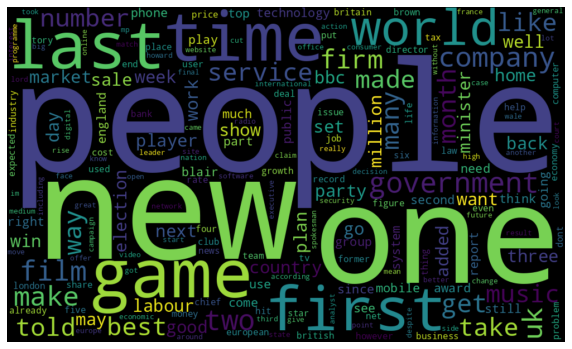

In [45]:
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

This is the WordCloud for our cleaned up text. We can see a lot of intent inside of this graphic, as well as it showing us places where we might further cull our list of words for topic modeling if we later decided to. We have a few names, numbers, and titles that might be good to remove if we wanted to do further refinement.

#### Generate n-grams and part of speech tagging
---

- **N-grams**

To create our various n-grams of word tuples and their frequency we will start with our tokens, use our nltk library and create another frequency array with the tuple and count of that tuple's occurences.

In [46]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

#regenerate the tokens list, remember we did more data cleaning since we last generated this list
tokens = ' '.join(bbc_df.clean_text).split()

In [47]:
# creating the bigrams
ngrams_2 = nltk.bigrams(tokens)

# freq distribution for these
freq_2grams = pd.Series(ngrams_2).value_counts().to_dict()
list(freq_2grams.items())[:20]

[(('told', 'bbc'), 348),
 (('prime', 'minister'), 319),
 (('chief', 'executive'), 206),
 (('last', 'week'), 188),
 (('tony', 'blair'), 186),
 (('mobile', 'phone'), 183),
 (('bbc', 'news'), 178),
 (('general', 'election'), 177),
 (('new', 'york'), 167),
 (('six', 'nation'), 162),
 (('liberal', 'democrat'), 157),
 (('number', 'one'), 147),
 (('first', 'time'), 140),
 (('michael', 'howard'), 130),
 (('last', 'month'), 122),
 (('human', 'right'), 118),
 (('bbc', 'radio'), 114),
 (('gordon', 'brown'), 113),
 (('interest', 'rate'), 113),
 (('lib', 'dems'), 106)]

We can see here how our removal of the `('said', 'mr')` tuple prior to reaching this point was replaced with a similar lexical element `('told','bbc')`. We also see a lot of repeated titles/names as part of these frequent bigrams, like prime minister, and bbc news.

In [48]:
# creating the trigrams
ngrams_3 = nltk.trigrams(tokens)

# freq distribution for these
freq_3grams = pd.Series(ngrams_3).value_counts().to_dict()
list(freq_3grams.items())[:20]

[(('told', 'bbc', 'news'), 147),
 (('bbc', 'news', 'website'), 97),
 (('told', 'bbc', 'radio'), 76),
 (('leader', 'michael', 'howard'), 58),
 (('million', 'dollar', 'baby'), 53),
 (('radio', 'today', 'programme'), 49),
 (('told', 'bbc', 'sport'), 48),
 (('bbc', 'radio', 'today'), 47),
 (('tory', 'leader', 'michael'), 41),
 (('next', 'general', 'election'), 39),
 (('chancellor', 'gordon', 'brown'), 33),
 (('minister', 'tony', 'blair'), 32),
 (('leader', 'charles', 'kennedy'), 32),
 (('prime', 'minister', 'tony'), 32),
 (('digital', 'music', 'player'), 30),
 (('world', 'number', 'one'), 27),
 (('coach', 'andy', 'robinson'), 27),
 (('bbc', 'world', 'service'), 26),
 (('london', 'stock', 'exchange'), 25),
 (('deputy', 'prime', 'minister'), 24)]

#### Part of speech
---

In [49]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

nltk.download('averaged_perceptron_tagger')

pos_tags = pos_tag(tokens)
pos_tags[:20]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tosterberg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('uk', 'JJ'),
 ('economy', 'NN'),
 ('facing', 'VBG'),
 ('major', 'JJ'),
 ('risk', 'NN'),
 ('uk', 'IN'),
 ('manufacturing', 'VBG'),
 ('sector', 'NN'),
 ('continue', 'VBP'),
 ('face', 'VBP'),
 ('serious', 'JJ'),
 ('challenge', 'NN'),
 ('next', 'JJ'),
 ('two', 'CD'),
 ('british', 'JJ'),
 ('chamber', 'NN'),
 ('commerce', 'NN'),
 ('bcc', 'NN'),
 ('group', 'NN'),
 ('quarterly', 'JJ')]

In [50]:
Counter([j for i,j in pos_tag(tokens)])

Counter({'JJ': 91403,
         'NN': 222698,
         'VBG': 20196,
         'IN': 8115,
         'VBP': 14101,
         'CD': 6672,
         'VBD': 28161,
         'RBS': 146,
         'RB': 21114,
         'VBN': 12721,
         'VB': 7629,
         'JJS': 2419,
         'JJR': 1817,
         'RBR': 1092,
         'NNS': 10348,
         'WP$': 123,
         'MD': 1279,
         'VBZ': 3307,
         'DT': 824,
         'NNP': 923,
         'CC': 278,
         'RP': 358,
         'FW': 784,
         'WRB': 54,
         'WDT': 62,
         'PRP': 120,
         'WP': 54,
         'POS': 6,
         'NNPS': 4,
         'PDT': 6,
         'PRP$': 14,
         'TO': 3,
         'UH': 4,
         'EX': 1})

It is interesting to see the frequencies of each of the parts of speech that are being used in these articles, but in order to go deeper into the analysis on how these articles are constructed and associated with distributions of parts of speech we would need to go to a differently cleaned text where we haven't removed stopwords or similar.

#### Topic Modeling
---

Modeling the topics for our texts is going to be a similar endeavor as our unsupervised learning that we did in last weeks lab. We will be seeing how we can split up our text articles, and then associating them with a topic. Afterwards we will look for the optimal number of topics by iterating through the likely range and choosing the best scoring model.

In [51]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

lem_ls = list(bbc_df.clean_text.apply(lambda x: list(x.split())))
print(lem_ls[:2])

[['uk', 'economy', 'facing', 'major', 'risk', 'uk', 'manufacturing', 'sector', 'continue', 'face', 'serious', 'challenge', 'next', 'two', 'british', 'chamber', 'commerce', 'bcc', 'group', 'quarterly', 'survey', 'company', 'found', 'export', 'picked', 'last', 'three', 'month', 'best', 'level', 'eight', 'rise', 'came', 'despite', 'exchange', 'rate', 'cited', 'major', 'concern', 'however', 'bcc', 'found', 'whole', 'uk', 'economy', 'still', 'faced', 'major', 'risk', 'warned', 'growth', 'set', 'slow', 'recently', 'forecast', 'economic', 'growth', 'slow', 'little', 'manufacturer', 'domestic', 'sale', 'growth', 'fell', 'back', 'slightly', 'quarter', 'survey', 'firm', 'found', 'employment', 'manufacturing', 'fell', 'job', 'expectation', 'lowest', 'level', 'despite', 'positive', 'news', 'export', 'sector', 'worrying', 'sign', 'manufacturing', 'bcc', 'result', 'reinforce', 'concern', 'sector', 'persistent', 'inability', 'sustain', 'recovery', 'outlook', 'service', 'sector', 'uncertain', 'despite

In [52]:
# Create Dictionary
id2word = corpora.Dictionary(lem_ls)

# Term Document Frequency Corpus
corpus = [id2word.doc2bow(post) for post in lem_ls]

In [53]:
# Build Basic LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [54]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())

[(0, '0.007*"people" + 0.005*"service" + 0.004*"mobile" + 0.004*"one" + 0.004*"uk" + 0.004*"new" + 0.004*"broadband" + 0.004*"phone" + 0.003*"show" + 0.003*"net"'), (1, '0.004*"government" + 0.004*"firm" + 0.004*"yukos" + 0.004*"company" + 0.004*"new" + 0.003*"law" + 0.003*"right" + 0.003*"people" + 0.003*"court" + 0.003*"told"'), (2, '0.006*"england" + 0.005*"government" + 0.005*"wale" + 0.004*"new" + 0.003*"game" + 0.003*"first" + 0.003*"rugby" + 0.003*"minister" + 0.003*"ireland" + 0.003*"six"'), (3, '0.006*"people" + 0.005*"user" + 0.005*"software" + 0.004*"new" + 0.004*"system" + 0.004*"company" + 0.004*"security" + 0.003*"firm" + 0.003*"search" + 0.003*"site"'), (4, '0.008*"game" + 0.007*"people" + 0.007*"music" + 0.005*"one" + 0.005*"new" + 0.005*"technology" + 0.005*"mobile" + 0.004*"time" + 0.004*"tv" + 0.004*"digital"'), (5, '0.008*"labour" + 0.006*"election" + 0.006*"party" + 0.006*"blair" + 0.006*"people" + 0.005*"brown" + 0.005*"tax" + 0.005*"tory" + 0.005*"minister" + 0.0

In [55]:
# compute the coherence score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=lem_ls, 
                                     dictionary=id2word, 
                                     coherence='c_v')

# retreive the coherence_scores
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4485662471546834


- **Finding the optimal number of topics**

In order to find our optimal number of topics we will loop through a few different values of the number of topics in our LDA model. We will assess the scores of those models for coherence and perplexity to determine our best model.

In [56]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View
# range of 2 to 14 topics

scores = []
for i in range(2,15):
    print(f'Calcuting for {i} topics')
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    # compute the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=lem_ls, 
                                         dictionary=id2word, 
                                         coherence='c_v')

    # retreive the coherence_scores
    coherence_lda = coherence_model_lda.get_coherence()
    
    # retreive the perplexity_scores
    perplexity_lda = lda_model.log_perplexity(corpus)
    
    scores.append((i,coherence_lda,perplexity_lda))

Calcuting for 2 topics
Calcuting for 3 topics
Calcuting for 4 topics
Calcuting for 5 topics
Calcuting for 6 topics
Calcuting for 7 topics
Calcuting for 8 topics
Calcuting for 9 topics
Calcuting for 10 topics
Calcuting for 11 topics
Calcuting for 12 topics
Calcuting for 13 topics
Calcuting for 14 topics


In [57]:
scores

[(2, 0.3387844256011157, -8.5283764373345),
 (3, 0.2954831128760326, -8.525773849180192),
 (4, 0.32265499093134387, -8.511329066942938),
 (5, 0.3328106708235007, -8.512661626545988),
 (6, 0.40465868461244753, -8.496911186867214),
 (7, 0.418512628563358, -8.50649464150951),
 (8, 0.4480337361595167, -8.487600533443976),
 (9, 0.4279715160336134, -8.513505818649119),
 (10, 0.4485662471546834, -8.502776629462467),
 (11, 0.4787693765638212, -8.518362744077772),
 (12, 0.47235407088006215, -8.533104836923805),
 (13, 0.47203862560005183, -8.53986962089531),
 (14, 0.4428911889840769, -8.552338492744921)]

From the scores collected it looks like our best model has 11 topics, since the coherence scores recede at that point and the perplexity is in the same ballpark. A case could be made for going with 12 topics as well, but I have chosen to prioritize the coherence measure.

- **Testing the accuracy of the model**

In [58]:
bf_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=11, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
# compute the coherence score
bf_coherence_model_lda = CoherenceModel(model=bf_lda_model, 
                                         texts=lem_ls, 
                                         dictionary=id2word, 
                                         coherence='c_v')

In [59]:
bf_coherence_model_lda.get_coherence()

0.4787693765638212

In [60]:
bf_lda_model.log_perplexity(corpus)

-8.518327333781803

I have chosen 11 topics for our model based off of the coherence and perplexity scores.

- **Print the topics**

In [61]:
bf_lda_model.show_topics(num_topics=11, num_words=15, log=False, formatted=True)

[(0,
  '0.008*"people" + 0.006*"mobile" + 0.006*"service" + 0.005*"phone" + 0.005*"uk" + 0.005*"broadband" + 0.005*"one" + 0.004*"technology" + 0.004*"new" + 0.004*"network" + 0.003*"net" + 0.003*"user" + 0.003*"get" + 0.003*"show" + 0.003*"use"'),
 (1,
  '0.005*"government" + 0.004*"firm" + 0.004*"company" + 0.004*"new" + 0.004*"yukos" + 0.004*"law" + 0.004*"right" + 0.003*"court" + 0.003*"told" + 0.003*"last" + 0.003*"people" + 0.003*"one" + 0.003*"oil" + 0.002*"share" + 0.002*"case"'),
 (2,
  '0.007*"england" + 0.006*"government" + 0.005*"wale" + 0.004*"new" + 0.003*"ireland" + 0.003*"rugby" + 0.003*"game" + 0.003*"six" + 0.003*"two" + 0.003*"first" + 0.003*"minister" + 0.003*"player" + 0.003*"world" + 0.003*"one" + 0.003*"nation"'),
 (3,
  '0.007*"people" + 0.006*"software" + 0.005*"user" + 0.005*"security" + 0.004*"new" + 0.004*"system" + 0.004*"site" + 0.004*"program" + 0.004*"virus" + 0.004*"firm" + 0.004*"company" + 0.004*"email" + 0.003*"use" + 0.003*"one" + 0.003*"net"'),
 (4

Our topics look like they can be summarized pretty well, although they don't map perfectly to our five types that we have from the dataset initially. Our topics do tend to look like subsets of those five types, where we have some topics that roll up into sports, business, technology, etc.

- **Graph the topics**

In [62]:
# Code adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(bf_lda_model, corpus, id2word)

In [63]:
# Saving the visualization to a html. Open this in another browser window
pyLDAvis.save_html(LDAvis_prepared,'topic_model_viz.html')

## V. Conclusion

From the analysis above and in the attached html document we can see that our topics are in general well separated and representative of the topics discussed. That being said it does appear that we have three topics that are very closely related, where category 1 actually wholely encircles category 11 and shares some overlap with category 10. If we felt that it was okay to stray from the highest coherence score and the direction of improving perplexity scores. Working from what we produced we can see that a coherence score of 0.4788 was our best of the tested range of topics, with a corresponding perplexity score of -8.5184. This was done using an implementation of Latent Dirichlet Allocation (LDA) for our topic modeling.

When looking at alternative models it looks like Latent Semantic Analysis (LSA), Non Negative Matrix Factorization (NMF), and some ensemble methods were the first choices. Additionally, we can look at the next step of this kind of analysis which would be to classify new text as it comes in and assign it to the correct topic. This could be accomplished by a number of algorithms, and even using K-means from our work last week which could then be judged by a silouette score. LDA could also be used to apply a classification to our data by calculating the values for each topic and selecting the highest value topic.

## VI. References

MSDS 650 - Week 7 Content:


1.) __[From the Experts: Text Processing](https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152323/View)__

2.) __[Week 7: Text Analytics](https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152319/View)__

3.) __[Week 7 Assignment](https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152317/View)__